KNN分类算法非常简单，该算法的核心思想是如果一个样本在特征空间中的k个最相邻的样本中的大多数属于某一个类别，则该样本也属于这个类别。该方法在确定分类决策上只依据最邻近K个样本的类别来决定待分样本所属的类别。KNN是一个懒惰算法，也就是说在平时不好好学习，考试（对测试样本分类）时才临阵发力（临时去找k个近邻），因此在预测的时候速度比较慢。

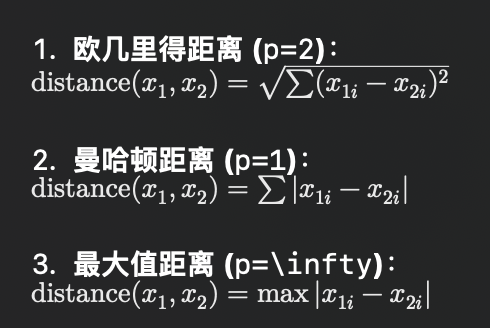

In [ ]:
# 导入必要的模块
import sys
import os
import math
import numpy as np

# 数据处理与可视化模块
from sklearn import datasets
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# 数据分析模块
from collections import Counter

In [ ]:
def shuffle_data(X, y, seed=None):
    """
    随机打乱数据集的特征和标签

    Parameters:
        X: 特征矩阵 (numpy array)
        y: 标签向量 (numpy array)
        seed: 随机种子 (int, optional)

    Returns:
        打乱后的特征矩阵和标签向量
    """
    if seed:
        np.random.seed(seed)  # 设置随机种子，保证结果可复现

    idx = np.arange(X.shape[0])  # 生成索引数组
    np.random.shuffle(idx)      # 打乱索引
    return X[idx], y[idx]       # 按打乱后的索引返回特征和标签


# 正规化数据集 X
def normalize(X, axis=-1, p=2):
    """
    使用 p 范数正规化特征矩阵

    Parameters:
        X: 特征矩阵 (numpy array)
        axis: 计算范数的轴 (int)
        p: 范数的阶数 (int)

    Returns:
        正规化后的特征矩阵
    """
    lp_norm = np.atleast_1d(np.linalg.norm(X, p, axis))  # 计算范数
    lp_norm[lp_norm == 0] = 1  # 避免除以零
    return X / np.expand_dims(lp_norm, axis)  # 返回正规化后的矩阵


# 标准化数据集 X
def standardize(X):
    """
    对特征矩阵进行标准化 (零均值，单位方差)

    Parameters:
        X: 特征矩阵 (numpy array)

    Returns:
        标准化后的特征矩阵
    """
    X_std = np.zeros(X.shape)  # 初始化标准化矩阵
    mean = X.mean(axis=0)      # 计算每列的均值
    std = X.std(axis=0)        # 计算每列的标准差

    for col in range(np.shape(X)[1]):  # 遍历每列
        if std[col]:  # 如果标准差不为 0
            X_std[:, col] = (X[:, col] - mean[col]) / std[col]  # 标准化
    return X_std


# 划分数据集为训练集和测试集
def train_test_split(X, y, test_size=0.2, shuffle=True, seed=None):
    """
    划分数据集为训练集和测试集

    Parameters:
        X: 特征矩阵 (numpy array)
        y: 标签向量 (numpy array)
        test_size: 测试集比例 (float)
        shuffle: 是否打乱数据 (bool)
        seed: 随机种子 (int, optional)

    Returns:
        x_train, x_test, y_train, y_test: 训练集和测试集的特征与标签
    """
    if shuffle:
        X, y = shuffle_data(X, y, seed)  # 打乱数据集

    n_train_samples = int(X.shape[0] * (1 - test_size))  # 计算训练集样本数量
    x_train, x_test = X[:n_train_samples], X[n_train_samples:]  # 划分特征
    y_train, y_test = y[:n_train_samples], y[n_train_samples:]  # 划分标签

    return x_train, x_test, y_train, y_test


# 计算分类准确率
def accuracy(y, y_pred):
    """
    计算预测的准确率

    Parameters:
        y: 实际标签 (numpy array)
        y_pred: 预测标签 (numpy array)

    Returns:
        准确率 (float)
    """
    y = y.reshape(y.shape[0], -1)       # 保证实际标签为二维矩阵
    y_pred = y_pred.reshape(y_pred.shape[0], -1)  # 保证预测标签为二维矩阵
    return np.sum(y == y_pred) / len(y)  # 计算匹配数量占比

In [5]:
class KNN():
    """ K近邻分类算法.

    Parameters:
    -----------
    k: int
        最近邻个数.
    """
    #定义近邻数，计算距离，找近邻数，投票选择分类
    def _init_ (self,k):
        self.k = k

    #计算欧式距离 
    def euclidean_distance(self,one_sample,X_train):
        #差值矩阵，平方差矩阵，每行求和，开平方
        one_sample = np.array(one_sample)
        X_train = np.array(X_train)
        distances = np.power(np.sum(np.square(one_sample-X_train),axis=1),0.5)
        return distances
    
    #计算曼哈顿距离
    def manhattan_distance(self,one_sample,X_train):
        one_sample = np.array(one_sample)
        X_train = np.array(X_train)
        distances = np.sum(np.abs(one_sample-X_train),axis=1)
        return distances

    #计算闵可夫斯基距离     
    def minkowski_distance(self,one_sample,X_train,p):
        one_sample = np.array(one_sample)
        X_train = np.array(X_train)
        distances = np.power(np.sum(np.abs(one_sample-X_train)**p),1/p)
        return distances
    
    #计算余弦距离
    def cosine_distance(self,one_sample,X_train):
        one_sample = np.array(one_sample)
        X_train = np.array(X_train)
        distances = np.sum(one_sample*X_train,axis=1)/(np.sqrt(np.sum(one_sample**2,axis=1))*np.sqrt(np.sum(X_train**2,axis=1)))
        return distances

    def get_k_neighbor_lables(self,distances,y_train,k):
        k_neighbor_lables = []
        for distance in np.sort(distances)[:k]: #取数据的前k个元素
            lable = y_train[distances == distance]
            k_neighbor_lables.append(lable)
        return np.array(k_neighbor_lables).reshape(-1,1)
        
    def vote(self,one_sample,X_train,y_train):
        distances = self.euclidean_distance(one_sample,X_train)
        y_train =np.array(y_train).reshape(y_train.shape[0],1)
        k_neighbor_lables = self.get_k_neighbor_lables(distances,y_train,k) #根据计算方式调整数据格式
        find_lable ,find_count = 0,0
        for lable , count in Counter(k_neighbor_lables).items():
            if count > find_count:
                find_count = count
                find_lable = lable
        return find_lable

    def predict(self,X_test,X_train,y_train):
        y_pred = []
        for one_sample in X_test:
            lable =self.vote(sample,X_train,y_train)
            y_pred.append(lable)    
        return np.array(y_pred)
        

    

In [ ]:
def main():
    data = make_classification(n_samples=200, n_features=4, n_informative=2, 
                               n_redundant=2, n_repeated=0, n_classes=2)
    X, y = data[0], data[1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
    clf = KNN(k=5)
    y_pred = clf.predict(X_test, X_train, y_train)
    
    accu = accuracy(y_test, y_pred)
    print ("Accuracy:", accu)

if __name__ == "__main__":
    main()

SyntaxError: incomplete input (2552824149.py, line 1)